## First goal: getting a filtration from data using existing tools

[([0], 0.0),
 ([1], 0.0),
 ([2], 0.0),
 ([3], 0.0),
 ([4], 0.0),
 ([5], 0.0),
 ([6], 0.0),
 ([7], 0.0),
 ([8], 0.0),
 ([9], 0.0),
 ([10], 0.0),
 ([11], 0.0),
 ([12], 0.0),
 ([13], 0.0),
 ([14], 0.0),
 ([15], 0.0),
 ([16], 0.0),
 ([17], 0.0),
 ([18], 0.0),
 ([19], 0.0),
 ([20], 0.0),
 ([21], 0.0),
 ([22], 0.0),
 ([23], 0.0),
 ([24], 0.0),
 ([25], 0.0),
 ([26], 0.0),
 ([27], 0.0),
 ([28], 0.0),
 ([29], 0.0),
 ([30], 0.0),
 ([31], 0.0),
 ([32], 0.0),
 ([33], 0.0),
 ([34], 0.0),
 ([35], 0.0),
 ([36], 0.0),
 ([37], 0.0),
 ([38], 0.0),
 ([39], 0.0),
 ([40], 0.0),
 ([41], 0.0),
 ([42], 0.0),
 ([43], 0.0),
 ([44], 0.0),
 ([45], 0.0),
 ([46], 0.0),
 ([47], 0.0),
 ([48], 0.0),
 ([49], 0.0),
 ([50], 0.0),
 ([51], 0.0),
 ([52], 0.0),
 ([53], 0.0),
 ([54], 0.0),
 ([55], 0.0),
 ([56], 0.0),
 ([57], 0.0),
 ([58], 0.0),
 ([59], 0.0),
 ([60], 0.0),
 ([61], 0.0),
 ([62], 0.0),
 ([63], 0.0),
 ([64], 0.0),
 ([65], 0.0),
 ([66], 0.0),
 ([67], 0.0),
 ([68], 0.0),
 ([69], 0.0),
 ([70], 0.0),
 ([71], 0.0),
 (

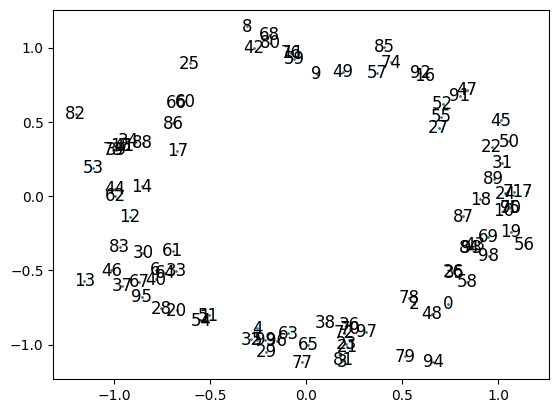

In [1]:
import numpy as np
import gudhi as gd
import tadasets
import matplotlib.pyplot as plt
from ripser import ripser
sphere = tadasets.dsphere(n=100, d=1, noise=0.1)
ripser(sphere)
plt.scatter(sphere[:,0], sphere[:,1], s=1)
for i, (x, y) in enumerate(sphere):
    plt.text(x, y, str(i), fontsize=12, ha='center', va='center')

rips = gd.RipsComplex(points=sphere, max_edge_length=0.5)
st = rips.create_simplex_tree(max_dimension=2)
st.compute_persistence()
filtration = list(st.get_filtration())

filtration

In [2]:
import numpy as np
from scipy.sparse import coo_matrix

# For now, this is slow. Probably want to move this to the Rust component, and pass the simplices directly at some point.
def compute_boundary_matrices(simplices):
    """
    Compute boundary matrices for a simplicial complex.

    Parameters:
    simplices (dict): Dictionary where keys are dimensions (int) and values are lists of tuples representing simplices.

    Returns:
    dict: Dictionary where keys are dimensions and values are NumPy arrays representing boundary matrices.
    """

    # Determine the maximum dimension
    max_dim = max(simplices.keys())

    # Create index mappings for each dimension
    index_maps = {
        dim: {simplex: idx for idx, simplex in enumerate(simplices[dim])}
        for dim in simplices
    }

    # Compute boundary matrices
    boundary_matrices = {}
    for dim in range(1, max_dim + 1):
        higher_simplices = simplices.get(dim, [])
        lower_simplices = simplices.get(dim - 1, [])
        lower_index_map = index_maps.get(dim - 1, {})

        rows = [] 
        cols = []
        data = []
        # for each of the higher simplices
        for col, simplex in enumerate(higher_simplices):
            # for each of the vertices of the simplex
            for i, _ in enumerate(simplex):
                # get face missing this index
                face = simplex[:i] + simplex[i+1:]
                # since this is a simplicial complex, the face is in the lower simplices
                row = lower_index_map.get(face)
                rows.append(row)
                cols.append(col)
                data.append((-1) ** i)
        
        # create sparse matrix
        n_rows = len(lower_simplices)
        n_cols = len(higher_simplices)
        boundary_matrices[dim] = {"n_rows": n_rows, "n_cols": n_cols, "data": np.asarray(data, dtype=np.float64), "rows": np.asarray(rows, dtype=np.int64), "cols": np.asarray(cols, dtype=np.int64)}

    return boundary_matrices

# example sanity check (triangle with point in middle)
simplices = {0: [(0,), (1, ), (2, ), (3,)], 1: [(2,3), (1,3), (1,2), (0,1), (0,2), (0,3)], 2: [(1,2,3), (0,2,3), (0,1,3)]}
bs = compute_boundary_matrices(simplices)
bs[2]

{'n_rows': 6,
 'n_cols': 3,
 'data': array([ 1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1.]),
 'rows': array([0, 1, 2, 0, 5, 4, 1, 5, 3]),
 'cols': array([0, 0, 0, 1, 1, 1, 2, 2, 2])}

In [3]:
from collections import defaultdict
# 1. Create the global boundary map
simplices_by_dim = defaultdict(list)
simplices_by_dim_only_filt = defaultdict(list)
for (simplex, filt_value) in filtration:
    dim = len(simplex) - 1
    simplices_by_dim[dim].append(tuple(sorted(simplex)))
    simplices_by_dim_only_filt[dim].append(filt_value)
b = compute_boundary_matrices(simplices_by_dim)

In [4]:
import bisect
def max_index(lst, b):
    # Find the insertion point for b to the right
    idx = bisect.bisect_right(lst, b)
    return idx 
unique_filtration_values = sorted(list(set([f for (_, f) in filtration])))
# print(simplices_by_dim_only_filt)
# For each filtration value, get indices for the boundary map at that filtration value
boundary_maps_index_dict = {filt_index: 
                                {  
                                    key : max_index(filt_values, filt_value)
                                    for key, filt_values in simplices_by_dim_only_filt.items()
                                } 
                                for (filt_index, filt_value) in enumerate(unique_filtration_values)
                            }

print(boundary_maps_index_dict)

{0: {0: 100, 1: 0, 2: 0}, 1: {0: 100, 1: 1, 2: 0}, 2: {0: 100, 1: 2, 2: 0}, 3: {0: 100, 1: 3, 2: 0}, 4: {0: 100, 1: 4, 2: 0}, 5: {0: 100, 1: 5, 2: 0}, 6: {0: 100, 1: 6, 2: 0}, 7: {0: 100, 1: 7, 2: 0}, 8: {0: 100, 1: 8, 2: 0}, 9: {0: 100, 1: 9, 2: 0}, 10: {0: 100, 1: 10, 2: 0}, 11: {0: 100, 1: 11, 2: 0}, 12: {0: 100, 1: 12, 2: 0}, 13: {0: 100, 1: 13, 2: 0}, 14: {0: 100, 1: 14, 2: 0}, 15: {0: 100, 1: 15, 2: 0}, 16: {0: 100, 1: 16, 2: 0}, 17: {0: 100, 1: 17, 2: 1}, 18: {0: 100, 1: 18, 2: 1}, 19: {0: 100, 1: 19, 2: 1}, 20: {0: 100, 1: 20, 2: 1}, 21: {0: 100, 1: 21, 2: 2}, 22: {0: 100, 1: 22, 2: 2}, 23: {0: 100, 1: 23, 2: 3}, 24: {0: 100, 1: 24, 2: 3}, 25: {0: 100, 1: 25, 2: 3}, 26: {0: 100, 1: 26, 2: 3}, 27: {0: 100, 1: 27, 2: 4}, 28: {0: 100, 1: 28, 2: 5}, 29: {0: 100, 1: 29, 2: 5}, 30: {0: 100, 1: 30, 2: 6}, 31: {0: 100, 1: 31, 2: 6}, 32: {0: 100, 1: 32, 2: 6}, 33: {0: 100, 1: 33, 2: 7}, 34: {0: 100, 1: 34, 2: 7}, 35: {0: 100, 1: 35, 2: 7}, 36: {0: 100, 1: 36, 2: 8}, 37: {0: 100, 1: 37, 

## Second goal: implementation of the Schur's complement Persistent Laplacian solver for a filtration

Assumption: the dimension of each $C_q^{d_i}$ increases by at most one with each increase in $i$.
Then we can implement _Theorem 5.1_ from Memoli.

In [5]:
import numpy as np
import persistent_laplacians
boundary_matrices = compute_boundary_matrices(simplices_by_dim)
print(boundary_matrices)
result = persistent_laplacians.process_tda(
    boundary_matrices,
    boundary_maps_index_dict
)
print("Rust returned:", result)

{1: {'n_rows': 100, 'n_cols': 782, 'data': array([ 1., -1.,  1., ..., -1.,  1., -1.], shape=(1564,)), 'rows': array([90, 75, 76, ..., 32, 98, 78], shape=(1564,)), 'cols': array([  0,   0,   1, ..., 780, 781, 781], shape=(1564,))}, 2: {'n_rows': 782, 'n_cols': 3082, 'data': array([ 1., -1.,  1., ...,  1., -1.,  1.], shape=(9246,)), 'rows': array([  0,  16,  15, ...,  73, 781, 706], shape=(9246,)), 'cols': array([   0,    0,    0, ..., 3081, 3081, 3081], shape=(9246,))}}
Value: {'n_rows': 100, 'n_cols': 782, 'data': array([ 1., -1.,  1., ..., -1.,  1., -1.], shape=(1564,)), 'rows': array([90, 75, 76, ..., 32, 98, 78], shape=(1564,)), 'cols': array([  0,   0,   1, ..., 780, 781, 781], shape=(1564,))}
Rust returned: 0
Value: {'n_rows': 782, 'n_cols': 3082, 'data': array([ 1., -1.,  1., ...,  1., -1.,  1.], shape=(9246,)), 'rows': array([  0,  16,  15, ...,  73, 781, 706], shape=(9246,)), 'cols': array([   0,    0,    0, ..., 3081, 3081, 3081], shape=(9246,))}
Filtration index: 782
Filtrati

## Third goal: Eigenvalue computations